Epoch 1/100, Loss: 150.5249, Accuracy: 37.40%, Validation Accuracy: 47.83%
Epoch 2/100, Loss: 101.2157, Accuracy: 53.82%, Validation Accuracy: 57.00%
Epoch 3/100, Loss: 82.9977, Accuracy: 61.63%, Validation Accuracy: 62.96%
Epoch 4/100, Loss: 69.4978, Accuracy: 67.18%, Validation Accuracy: 60.57%
Epoch 5/100, Loss: 61.2572, Accuracy: 70.67%, Validation Accuracy: 73.94%
Epoch 6/100, Loss: 54.1048, Accuracy: 73.87%, Validation Accuracy: 73.65%
Epoch 7/100, Loss: 42.1505, Accuracy: 80.80%, Validation Accuracy: 77.11%
Epoch 8/100, Loss: 34.2785, Accuracy: 84.22%, Validation Accuracy: 77.94%
Epoch 9/100, Loss: 31.4346, Accuracy: 85.83%, Validation Accuracy: 89.75%
Epoch 10/100, Loss: 19.4540, Accuracy: 92.52%, Validation Accuracy: 93.27%
Epoch 11/100, Loss: 15.6253, Accuracy: 94.21%, Validation Accuracy: 94.14%
Epoch 12/100, Loss: 17.1573, Accuracy: 93.52%, Validation Accuracy: 93.12%
Epoch 13/100, Loss: 12.3541, Accuracy: 95.39%, Validation Accuracy: 94.24%
Epoch 14/100, Loss: 9.5466, Accu

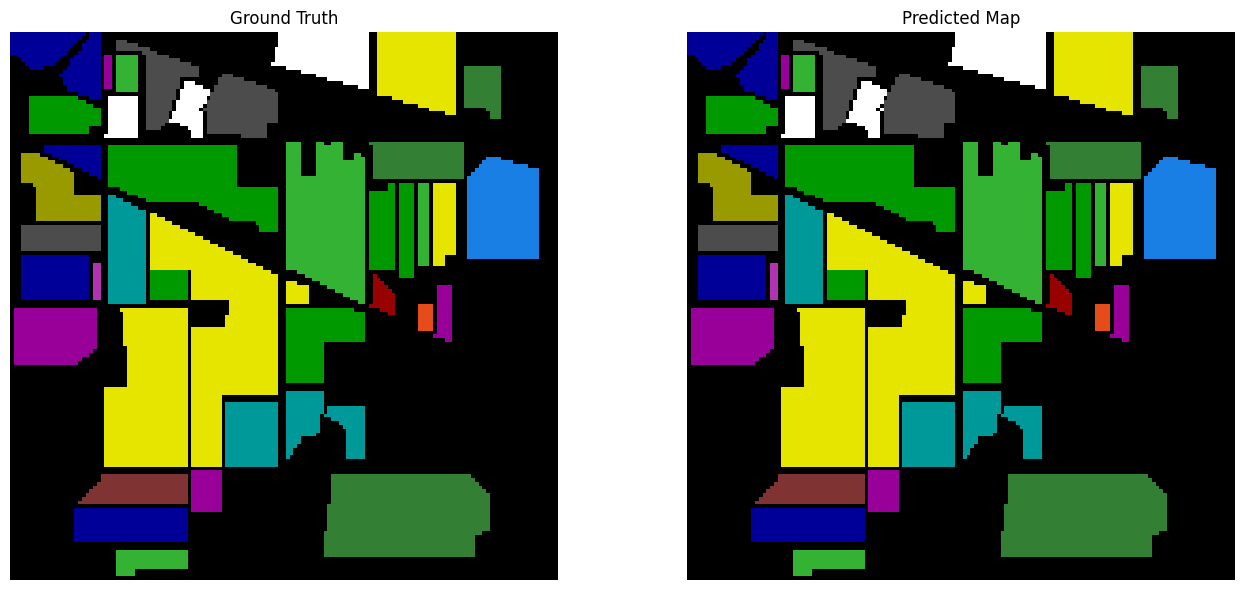

<Figure size 640x480 with 0 Axes>

In [3]:
# Importujemy wymagane biblioteki
import os
import urllib.request
import scipy.io as sio
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, BoundaryNorm
import csv

# Parametry
patch_size = 16

# Funkcja do pobierania plików
def download_file(url, filename):
    if not os.path.exists(filename):
        print(f"Pobieranie {filename}...")
        urllib.request.urlretrieve(url, filename)
        print(f"Pobrano {filename}")

# Ładowanie danych
def load_indian_pines():
    data_url = "https://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat"
    label_url = "https://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat"
    data_file = "Indian_pines_corrected.mat"
    label_file = "Indian_pines_gt.mat"
    download_file(data_url, data_file)
    download_file(label_url, label_file)
    data = sio.loadmat(data_file)["indian_pines_corrected"]
    labels = sio.loadmat(label_file)["indian_pines_gt"]
    return data, labels

# Normalizacja
def normalize(data):
    h, w, b = data.shape
    data = data.reshape(-1, b)
    data = MinMaxScaler().fit_transform(data)
    return data.reshape(h, w, b)

# Padding
def pad_with_zeros(data, margin):
    return np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')

# Dataset
class HSI_Dataset(Dataset):
    def __init__(self, patch_size=patch_size):
        data, labels = load_indian_pines()
        data = normalize(data)
        margin = patch_size // 2
        padded_data = pad_with_zeros(data, margin)

        h, w, _ = data.shape
        self.patches = []
        self.targets = []

        for i in range(h):
            for j in range(w):
                label = labels[i, j]
                if label == 0:
                    continue
                patch = padded_data[i:i+patch_size, j:j+patch_size, :]
                self.patches.append(patch)
                self.targets.append(label - 1)

        self.patches = np.array(self.patches)
        self.patches = np.transpose(self.patches, (0, 3, 1, 2))  # (N, B, H, W)
        self.targets = np.array(self.targets)

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        return torch.tensor(self.patches[idx], dtype=torch.float32), torch.tensor(self.targets[idx], dtype=torch.long)

# Loadery
def get_loaders(batch_size=32, patch_size=patch_size, val_split=0.2):
    dataset = HSI_Dataset(patch_size)
    val_len = int(len(dataset) * val_split)
    train_len = len(dataset) - val_len
    train_set, val_set = random_split(dataset, [train_len, val_len])
    return DataLoader(train_set, batch_size=batch_size, shuffle=True), DataLoader(val_set, batch_size=batch_size)

# CNN z diagramu
class CNNFromDiagram(nn.Module):
    def __init__(self, input_channels=200, num_classes=16, patch_size=16):
        super(CNNFromDiagram, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=100, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=100, out_channels=100, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        # Oblicz rozmiar wyjścia po konwolucjach
        dummy_input = torch.zeros(1, input_channels, patch_size, patch_size)
        x = self.pool1(F.relu(self.conv1(dummy_input)))
        x = self.pool2(F.relu(self.conv2(x)))
        flatten_dim = x.view(1, -1).shape[1]  # <-- to oblicza prawidłowy rozmiar

        self.fc1 = nn.Linear(flatten_dim, 84)
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Trenowanie
def train(model, train_loader, val_loader, epochs=10, lr=0.001, device="cuda" if torch.cuda.is_available() else "cpu"):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    with open("training_log.csv", mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Epoch", "Train Loss", "Train Accuracy", "Validation Accuracy"])

        for epoch in range(epochs):
            model.train()
            total_loss, correct = 0, 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                correct += (outputs.argmax(1) == labels).sum().item()

            acc = 100.0 * correct / len(train_loader.dataset)

            model.eval()
            val_correct = 0
            with torch.no_grad():
                for val_inputs, val_labels in val_loader:
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                    val_outputs = model(val_inputs)
                    val_correct += (val_outputs.argmax(1) == val_labels).sum().item()
            val_acc = 100.0 * val_correct / len(val_loader.dataset)

            writer.writerow([epoch + 1, total_loss, acc, val_acc])
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}, Accuracy: {acc:.2f}%, Validation Accuracy: {val_acc:.2f}%")

# Predykcja całej sceny
def predict_whole_scene(model, patch_size=16, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.eval()
    model.to(device)

    data, labels = load_indian_pines()
    data = normalize(data)
    h, w, b = data.shape
    margin = patch_size // 2
    padded_data = pad_with_zeros(data, margin)
    output = np.zeros((h, w), dtype=np.uint8)

    for i in range(h):
        for j in range(w):
            if labels[i, j] == 0:
                continue
            patch = padded_data[i:i+patch_size, j:j+patch_size, :]
            patch = np.expand_dims(patch, axis=0)
            patch = np.transpose(patch, (0, 3, 1, 2))  # (1, B, H, W)
            patch = torch.tensor(patch, dtype=torch.float32).to(device)

            with torch.no_grad():
                pred = model(patch)
                output[i, j] = pred.argmax(1).item() + 1  # +1 by pasowało do etykiet

    return output, labels

# Wizualizacja
def visualize(pred_map, true_map):
    class_names = [
        "Background", "Alfalfa", "Corn-notill", "Corn-mintill", "Corn",
        "Grass-pasture", "Grass-trees", "Grass-pasture-mowed", "Hay-windrowed",
        "Oats", "Soybean-notill", "Soybean-mintill", "Soybean-clean",
        "Wheat", "Woods", "Buildings-Grass-Trees-Drives", "Stone-Steel-Towers"
    ]

    cmap = ListedColormap([
        (0, 0, 0), (0.6, 0, 0), (0, 0.6, 0), (0, 0, 0.6), (0.6, 0.6, 0),
        (0.6, 0, 0.6), (0, 0.6, 0.6), (0.9, 0.3, 0.1), (0.1, 0.5, 0.9),
        (0.7, 0.2, 0.7), (0.2, 0.7, 0.2), (0.9, 0.9, 0), (0.3, 0.3, 0.3),
        (0.5, 0.2, 0.2), (0.2, 0.5, 0.2), (0.2, 0.2, 0.5), (1.0, 1.0, 1.0)
    ])

    norm = BoundaryNorm(boundaries=np.arange(17) - 0.5, ncolors=17)

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    axs[0].imshow(true_map, cmap=cmap, norm=norm)
    axs[0].set_title("Ground Truth")
    axs[0].axis("off")

    axs[1].imshow(pred_map, cmap=cmap, norm=norm)
    axs[1].set_title("Predicted Map")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

    patches = [mpatches.Patch(color=cmap(i), label=f"{i}: {class_names[i]}")
               for i in range(1, len(class_names))]
    fig.legend(handles=patches, loc='center right', bbox_to_anchor=(1.15, 0.5), title="Classes")
    plt.tight_layout()
    plt.show()

# Główne wywołanie
if __name__ == "__main__":
    train_loader, val_loader = get_loaders(batch_size=100, patch_size=patch_size)
    model = CNNFromDiagram(input_channels=200, num_classes=16, patch_size=patch_size)
    train(model, train_loader, val_loader, epochs=100)
    pred_map, true_map = predict_whole_scene(model, patch_size=patch_size)
    visualize(pred_map, true_map)
